In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os
import numpy as np
from typing import NoReturn, Optional, Tuple, List

## Install Packages

In [2]:
!pip install ultralytics
!pip install git+https://github.com/allegroai/clearml
!pip install clearml-agent

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.2/716.2 kB 17.7 MB/s eta 0:00:0000:01
  Cloning https://github.com/allegroai/clearml to /tmp/pip-req-build-o9t59ezn
  Running command git clone --filter=blob:none --quiet https://github.com/allegroai/clearml /tmp/pip-req-build-o9t59ezn
  Resolved https://github.com/allegroai/clearml to commit 1320927fdfa2f1feef02caa98bb87e7dfa5dfe52
  Preparing metadata (setup.py) ... done
  Created wheel for clearml: filename=clearml-1.14.4-py2.py3-none-any.whl size=1135890 sha256=9593e5f323b3c7dbc5775501bb6b2a2ba876dc5f79a72a20d74062256f94465e
  Stored in directory: /tmp/pip-ephem-wheel-cache-fzk25lln/wheels/c3/cb/b6/3cbc932bc45b51ba5c2a0c14d9db80499ad5f6869fe8b26a7d
Successfully built clearml
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 420.3/420.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

## Configure ClearML

In [4]:
from clearml import Task


Task.set_credentials(
     api_host="https://api.clear.ml",
     web_host="https://app.clear.ml",
     files_host="https://files.clear.ml",
     key="BETHQ7GJD6UHDRHLLKC7",
     secret=os.environ["SECRET"]
)

In [5]:
!clearml-agent daemon --queue default

Using environment access key CLEARML_API_ACCESS_KEY=BETHQ7GJD6UHDRHLLKC7
Using environment secret key CLEARML_API_SECRET_KEY=********
Current configuration (clearml_agent v1.7.0, location: None):
----------------------
api.version = 1.5
api.verify_certificate = true
api.default_version = 1.5
api.http.max_req_size = 15728640
api.http.retries.total = 240
api.http.retries.connect = 240
api.http.retries.read = 240
api.http.retries.redirect = 240
api.http.retries.status = 240
api.http.retries.backoff_factor = 1.0
api.http.retries.backoff_max = 120.0
api.http.wait_on_maintenance_forever = true
api.http.pool_maxsize = 512
api.http.pool_connections = 512
api.api_server = https://api.clear.ml
api.files_server = https://files.clear.ml
api.web_server = https://app.clear.ml
api.credentials.access_key = BETHQ7GJD6UHDRHLLKC7
agent.worker_id = 
agent.worker_name = 2c6d00d09327
agent.force_git_ssh_protocol = false
agent.python_binary = 
agent.package_manager.type = pip
agent.package_manager.pip_versio

## Download the Dataset

In [6]:
os.makedirs("datasets", exist_ok=True)

In [7]:
%cd datasets

/kaggle/working/datasets


In [8]:
def download_file(url: str, save_name: str) -> NoReturn:
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, "wb").write(file.content)


download_file(
    "https://universe.roboflow.com/ds/aWSzEuG4gn?key=B5rr6UiJZh",
    "apple_dataset_v8.zip"
)

In [9]:
# Unzip the data file
def unzip(zip_file : Optional[str] = None) -> NoReturn:
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")


unzip("apple_dataset_v8.zip")

Extracted all


## Visualize Images from the Dataset

In [10]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(box: List[float]) -> Tuple[float, float, float, float]:
    xmin, ymin = box[0] - box[2] / 2, box[1] - box[3] / 2
    xmax, ymax = box[0] + box[2] / 2, box[1] + box[3] / 2
    return xmin, ymin, xmax, ymax

In [11]:
def plot_box(
    image: np.ndarray,
    bboxes: List[List[float]]
) -> np.ndarray:
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [12]:
# Function to plot images with the bounding boxes.
def plot(image_paths: str, label_paths: str, num_samples: int) -> NoReturn:
    all_images = sorted(glob.glob(image_paths+"/*.jpg") + glob.glob(image_paths+"/*.JPG"))
    num_images = len(all_images)
    plt.figure(figsize=(9, 16))
    for i in range(num_samples):
        j = random.randint(0, num_images-1)
        image_name = all_images[j]
        image_name = ".".join(image_name.split(os.path.sep)[-1].split(".")[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+".txt"), "r") as f:
            bboxes = list()
            labels = list()
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split()
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis("off")
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

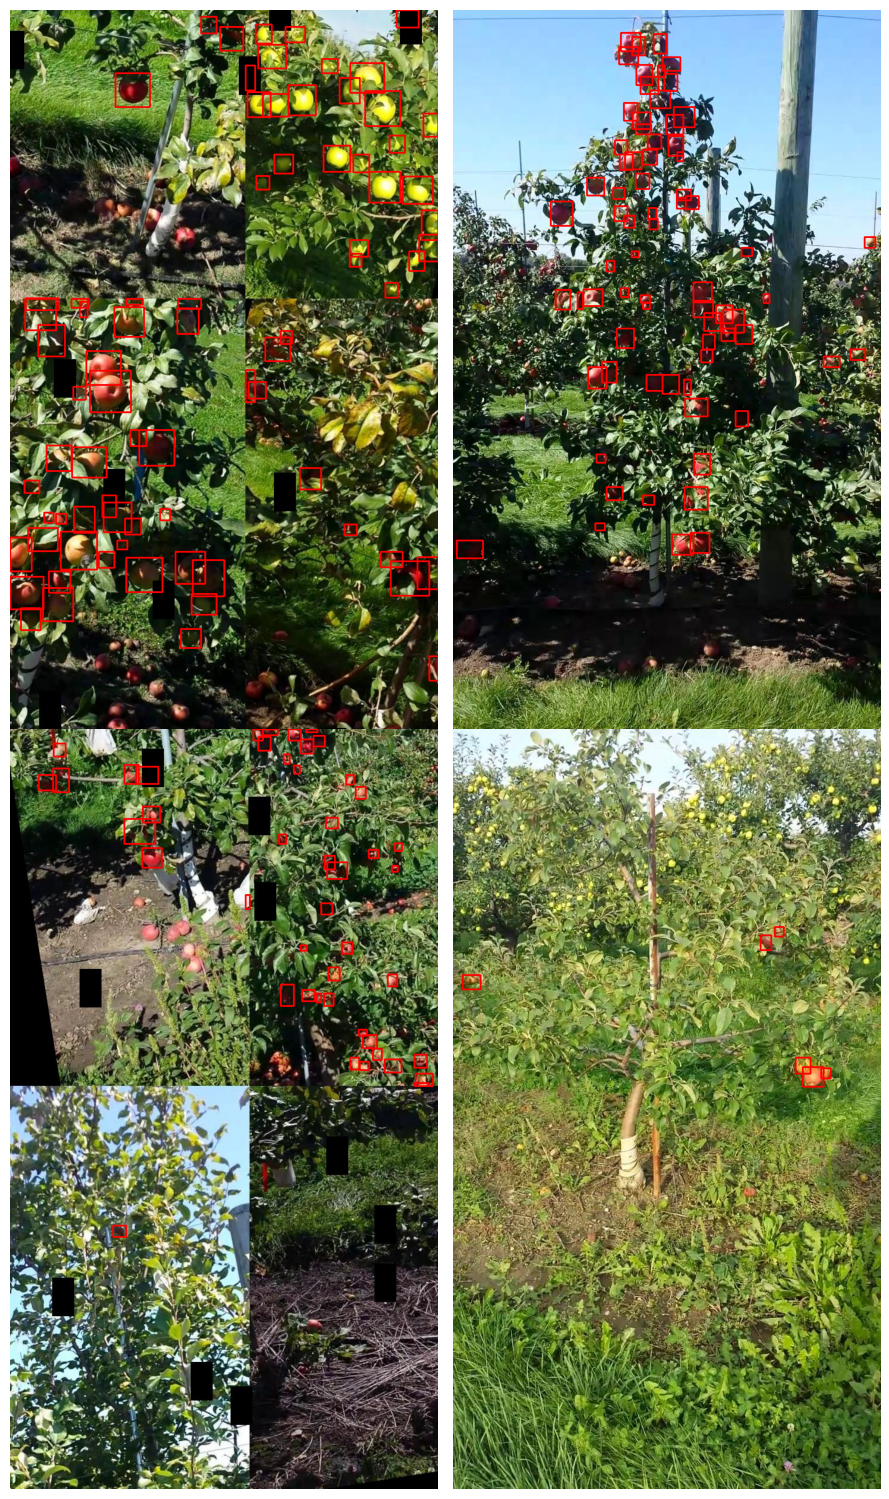

In [13]:
# Visualize a few training images.
plot(
    image_paths="train/images/",
    label_paths="train/labels/",
    num_samples=4
)

## Selection of Hyperparameters

In [14]:
from ultralytics import YOLO

# Load the model.
model = YOLO("yolov8s.pt")

parameters = {
    "data": "data.yaml",
    "imgsz": [720, 1280],
    "batch": 8,
    "device": [0, 1]
}


const_parameters = {
    "degrees": 0,
    "dfl": 1.5,
    "translate" : 0,
    "shear": 0,
    "perspective": 0,
    "flipud": 0,
    "fliplr": 0.5,
    "mosaic": 0,
    "mixup": 0,
    "copy_paste": 0
}


train_parameters = {
    "epochs": 10,
    "optimizer": "AdamW",
    "cos_lr": True
}

result_grid = model.tune(
    **parameters,
    **const_parameters,
    **train_parameters,
    iterations=10
)


In [15]:
import yaml


with open("/kaggle/input/tune-results/best_hyperparameters.yaml", "r") as f:
    best_parameters = yaml.safe_load(f)

## YOLOv8 Small Training

In [ ]:
model = YOLO("/kaggle/input/tune-results/best-5.pt")


parameters = {
    "data": "data.yaml",
    "imgsz": [720, 1280],
    "batch": 8,
    "device": [0, 1]
}


EPOCHS = 80


train_parameters = {
    "epochs": EPOCHS,
    "optimizer": "AdamW",
    "cos_lr": True
}


# Training.
results = model.train(
    **best_parameters,
    **parameters,
    **train_parameters,
    name=f"yolov8s_{EPOCHS}e"
)

Ultralytics YOLOv8.1.19 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/kaggle/input/tune-results/best-5.pt, data=data.yaml, epochs=80, time=None, patience=100, batch=8, imgsz=[720, 1280], save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=yolov8s_80e3, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_fr

2024-02-29 10:07:11.986956: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-29 10:07:11.987009: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-29 10:07:11.988598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorBoard: Start with 'tensorboard --logdir runs/detect/yolov8s_80e3', view at http://localhost:6006/


wandb: Currently logged in as: concussive. Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.3 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.16.2
wandb: Run data is saved locally in /kaggle/working/datasets/wandb/run-20240229_100718-rwacf1pz
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run yolov8s_80e3
wandb: ⭐️ View project at https://wandb.ai/concussive/YOLOv8
wandb: 🚀 View run at https://wandb.ai/concussive/YOLOv8/runs/rwacf1pz


Transferred 355/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1280'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/working/datasets/train/labels.cache... 1402 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1402/1402 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/datasets/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolov8s_80e3/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1280 train, 1280 val
Using 4 dataloader workers
Logging results to runs/detect/yolov8s_80e3
Starting training for 80 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/80      5.48G      1.657     0.9601      1.179          8       1280: 100%|██████████| 176/176 [01:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:05<00:00,  4.96it/s]


                   all        200       7992      0.733      0.655      0.746      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/80      5.92G      1.706      1.029       1.19          8       1280: 100%|██████████| 176/176 [01:02<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


                   all        200       7992      0.797      0.641      0.763       0.41

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/80      5.78G      1.706       1.01      1.193          8       1280: 100%|██████████| 176/176 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.28it/s]


                   all        200       7992      0.805      0.713      0.813      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/80      5.16G      1.711      1.107      1.191          8       1280: 100%|██████████| 176/176 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.29it/s]


                   all        200       7992      0.705      0.631      0.695      0.378

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/80      4.93G      1.731      1.084      1.189         49       1280: 100%|██████████| 176/176 [00:55<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


                   all        200       7992       0.81      0.729      0.826      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/80      5.72G      1.708      1.042      1.191         75       1280: 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


                   all        200       7992      0.815      0.704       0.81      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/80      5.06G      1.715      1.034      1.197         60       1280: 100%|██████████| 176/176 [00:56<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


                   all        200       7992      0.821      0.693      0.813      0.432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/80      5.95G      1.717      1.008      1.196         36       1280: 100%|██████████| 176/176 [00:56<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


                   all        200       7992      0.833      0.721       0.83      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/80      6.33G      1.688     0.9718      1.173         53       1280: 100%|██████████| 176/176 [00:56<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


                   all        200       7992      0.828      0.715      0.824      0.441

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/80      5.73G       1.66     0.9498      1.174         26       1280: 100%|██████████| 176/176 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


                   all        200       7992      0.825      0.737       0.84      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/80      6.04G      1.677     0.9738       1.18         22       1280: 100%|██████████| 176/176 [00:55<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


                   all        200       7992      0.793      0.702      0.803      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/80      5.12G      1.723      1.004      1.192         31       1280: 100%|██████████| 176/176 [00:55<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.62it/s]


                   all        200       7992      0.811      0.724       0.82      0.443

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/80       5.1G      1.651     0.9382      1.175         34       1280: 100%|██████████| 176/176 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.78it/s]


                   all        200       7992      0.826      0.723      0.828      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/80      5.96G      1.648     0.9602      1.175         28       1280: 100%|██████████| 176/176 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.58it/s]


                   all        200       7992      0.824      0.718      0.823       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/80      6.42G      1.654     0.9276      1.169         56       1280: 100%|██████████| 176/176 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.41it/s]


                   all        200       7992      0.823      0.745      0.837      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/80      4.78G      1.627     0.9088      1.151         15       1280: 100%|██████████| 176/176 [00:55<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


                   all        200       7992       0.84      0.746      0.841      0.467

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/80      5.24G      1.638     0.9205       1.15         33       1280: 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.38it/s]


                   all        200       7992       0.84      0.753      0.848      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/80      5.83G      1.627     0.9185      1.148         58       1280: 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.69it/s]


                   all        200       7992      0.839      0.738      0.844      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/80      5.64G      1.626     0.9223      1.159         63       1280: 100%|██████████| 176/176 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


                   all        200       7992      0.844      0.738      0.845      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/80      5.39G      1.623      0.898      1.155         39       1280: 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.47it/s]


                   all        200       7992      0.837      0.754      0.851      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/80      5.14G      1.607     0.8663      1.148         81       1280: 100%|██████████| 176/176 [00:55<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


                   all        200       7992      0.825      0.758      0.849      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/80      5.59G      1.636     0.9089      1.153         16       1280: 100%|██████████| 176/176 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.66it/s]


                   all        200       7992      0.837       0.77      0.859      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/80       5.4G      1.611     0.9233      1.141         18       1280: 100%|██████████| 176/176 [00:56<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


                   all        200       7992      0.837      0.755       0.85      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/80      4.57G      1.604     0.8905      1.157         55       1280: 100%|██████████| 176/176 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.50it/s]


                   all        200       7992      0.856      0.762      0.862      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/80      5.79G       1.59     0.8589      1.142         41       1280: 100%|██████████| 176/176 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.73it/s]


                   all        200       7992      0.843      0.746      0.849      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/80      5.74G      1.622     0.8761      1.143         42       1280: 100%|██████████| 176/176 [00:55<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


                   all        200       7992      0.844       0.76       0.85      0.479

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/80      4.63G      1.611     0.8735      1.139         49       1280: 100%|██████████| 176/176 [00:56<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.40it/s]


                   all        200       7992      0.832      0.734      0.841      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/80      5.62G      1.667     0.9202      1.169         60       1280: 100%|██████████| 176/176 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.43it/s]


                   all        200       7992      0.846      0.731      0.843      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/80      6.05G      1.602     0.8803      1.156         71       1280: 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


                   all        200       7992       0.86      0.764      0.862      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/80      5.49G      1.601     0.8597      1.147         44       1280: 100%|██████████| 176/176 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


                   all        200       7992       0.86       0.78      0.873      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/80      5.36G       1.61      0.857      1.151         59       1280: 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.80it/s]


                   all        200       7992      0.826      0.741      0.839      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/80      5.13G      1.574     0.8461      1.139         45       1280: 100%|██████████| 176/176 [00:56<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.54it/s]


                   all        200       7992      0.855      0.768      0.858      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/80      5.84G      1.583     0.8405       1.13         50       1280: 100%|██████████| 176/176 [00:56<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


                   all        200       7992      0.859      0.765       0.86      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/80      5.04G      1.564     0.8243       1.13         55       1280: 100%|██████████| 176/176 [00:56<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.63it/s]


                   all        200       7992      0.852      0.775      0.865      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/80      4.98G      1.578     0.8331      1.129         53       1280: 100%|██████████| 176/176 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.60it/s]


                   all        200       7992      0.854      0.774      0.869      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/80      5.16G       1.58     0.8272      1.139         91       1280: 100%|██████████| 176/176 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.49it/s]


                   all        200       7992      0.855      0.769      0.868      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/80       5.6G      1.566     0.8147       1.12         30       1280: 100%|██████████| 176/176 [00:56<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.81it/s]


                   all        200       7992      0.868      0.771      0.867      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/80      4.93G      1.572     0.8179      1.134         97       1280: 100%|██████████| 176/176 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.59it/s]


                   all        200       7992      0.861      0.776      0.872      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/80      4.79G      1.588     0.8254      1.128         57       1280: 100%|██████████| 176/176 [00:56<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


                   all        200       7992      0.856      0.779      0.869      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/80      5.02G      1.547     0.7989      1.117         60       1280: 100%|██████████| 176/176 [00:56<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.52it/s]


                   all        200       7992      0.859       0.78      0.872       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/80      5.69G      1.561     0.8171      1.127        122       1280: 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.34it/s]


                   all        200       7992      0.863      0.788      0.878      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/80      5.83G      1.562     0.8104      1.131         52       1280: 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.71it/s]


                   all        200       7992      0.821      0.747      0.841      0.472

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/80      5.16G      1.556     0.7968      1.123         10       1280: 100%|██████████| 176/176 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


                   all        200       7992      0.857      0.768      0.864      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/80      5.52G      1.559     0.8043      1.118          6       1280: 100%|██████████| 176/176 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


                   all        200       7992      0.862      0.782      0.874      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/80      4.69G      1.528     0.7875      1.103         41       1280: 100%|██████████| 176/176 [00:56<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


                   all        200       7992      0.865      0.785      0.875      0.497

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/80      5.09G       1.54     0.7792      1.122         30       1280: 100%|██████████| 176/176 [00:56<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.75it/s]


                   all        200       7992      0.865      0.783      0.873      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/80      5.62G      1.532     0.7787      1.116         66       1280: 100%|██████████| 176/176 [00:56<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


                   all        200       7992      0.875      0.789      0.878      0.502

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/80      5.18G      1.534     0.7691      1.121         21       1280: 100%|██████████| 176/176 [00:56<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.51it/s]


                   all        200       7992      0.873      0.776      0.876      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/80      4.93G      1.529     0.7699      1.114         34       1280: 100%|██████████| 176/176 [00:56<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.74it/s]


                   all        200       7992      0.852      0.779      0.859      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/80       6.6G      1.523     0.7868      1.106         32       1280: 100%|██████████| 176/176 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.68it/s]


                   all        200       7992      0.872      0.779      0.875      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/80      5.97G      1.514     0.7721      1.106         51       1280: 100%|██████████| 176/176 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.65it/s]


                   all        200       7992      0.865      0.799      0.882      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/80      4.76G      1.513     0.7543      1.093         64       1280: 100%|██████████| 176/176 [00:57<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.67it/s]


                   all        200       7992      0.868      0.783      0.877      0.493

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/80      5.99G      1.507     0.7508      1.097         49       1280: 100%|██████████| 176/176 [00:56<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.45it/s]


                   all        200       7992      0.876      0.796      0.884        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/80      5.39G      1.503     0.7422      1.098          6       1280: 100%|██████████| 176/176 [00:56<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.35it/s]


                   all        200       7992      0.875      0.798      0.885      0.507

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/80      5.57G      1.491     0.7428      1.101          4       1280: 100%|██████████| 176/176 [00:56<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


                   all        200       7992      0.877      0.794      0.882      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/80      5.69G      1.495     0.7448      1.104         60       1280: 100%|██████████| 176/176 [00:56<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.56it/s]


                   all        200       7992      0.864      0.799       0.88        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/80      5.42G      1.487     0.7325      1.106         16       1280: 100%|██████████| 176/176 [00:55<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.70it/s]


                   all        200       7992      0.878      0.797      0.885      0.508

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/80      5.47G      1.494     0.7394      1.089         49       1280: 100%|██████████| 176/176 [00:56<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.77it/s]


                   all        200       7992      0.869      0.799      0.878      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/80      5.33G      1.505     0.7409      1.099         76       1280: 100%|██████████| 176/176 [00:55<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:03<00:00,  6.76it/s]


                   all        200       7992       0.87      0.797       0.88      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/80      4.46G      1.565     0.7375      1.127        230       1280:   2%|▏         | 4/176 [00:01<00:52,  3.27it/s]

## Evaluation on Validation Images

In [19]:
best_model = YOLO("runs/detect/yolov8s_80e3/weights/best.pt")


results = best_model.val(
   **parameters,
   name='yolov8s_80e_e',
)

WARNING ⚠️ updating to 'imgsz=1280'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'
Ultralytics YOLOv8.1.19 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11125971 parameters, 0 gradients, 28.4 GFLOPs


val: Scanning /kaggle/working/datasets/valid/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 25/25 [00:24<00:00,  1.00it/s]


                   all        200       7992       0.88      0.797      0.885      0.508
Speed: 0.6ms preprocess, 21.8ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to runs/detect/yolov8s_80e_e


## Inference on Validation Images

In [52]:
results = best_model.predict(
    imgsz=[720, 1280],
    device=[0, 1],
    source="test/images/", # kaggle/working/datasets/
    show_labels=True,
    name="yolov8s_80e_p",
    save=True,
    conf=0.5
)


WARNING ⚠️ imgsz=[720, 1280] must be multiple of max stride 32, updating to [736, 1280]
image 1/100 /kaggle/working/datasets/test/images/20150919_174151_image121_png_jpg.rf.b7fc2478313627f87bcbeb831933faf2.jpg: 736x416 65 apples, 13.8ms
image 2/100 /kaggle/working/datasets/test/images/20150919_174151_image161_png_jpg.rf.5e7093b1eab8189a7bb39c635604d7d4.jpg: 736x416 73 apples, 13.7ms
image 3/100 /kaggle/working/datasets/test/images/20150919_174151_image176_png_jpg.rf.e7b9c05430d01dfbc614407195412ab9.jpg: 736x416 75 apples, 13.7ms
image 4/100 /kaggle/working/datasets/test/images/20150919_174151_image191_png_jpg.rf.f25042bdfa572e9d139bc0237e90058c.jpg: 736x416 63 apples, 13.7ms
image 5/100 /kaggle/working/datasets/test/images/20150919_174151_image211_png_jpg.rf.6ae0a1c0fb085c632104abcc032f49f4.jpg: 736x416 64 apples, 13.7ms
image 6/100 /kaggle/working/datasets/test/images/20150919_174151_image241_png_jpg.rf.84797c407bce9d90d553e0c84df00d01.jpg: 736x416 62 apples, 13.7ms
image 7/100 /kagg

## Visualize Validation Results

In [53]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(9, 16))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

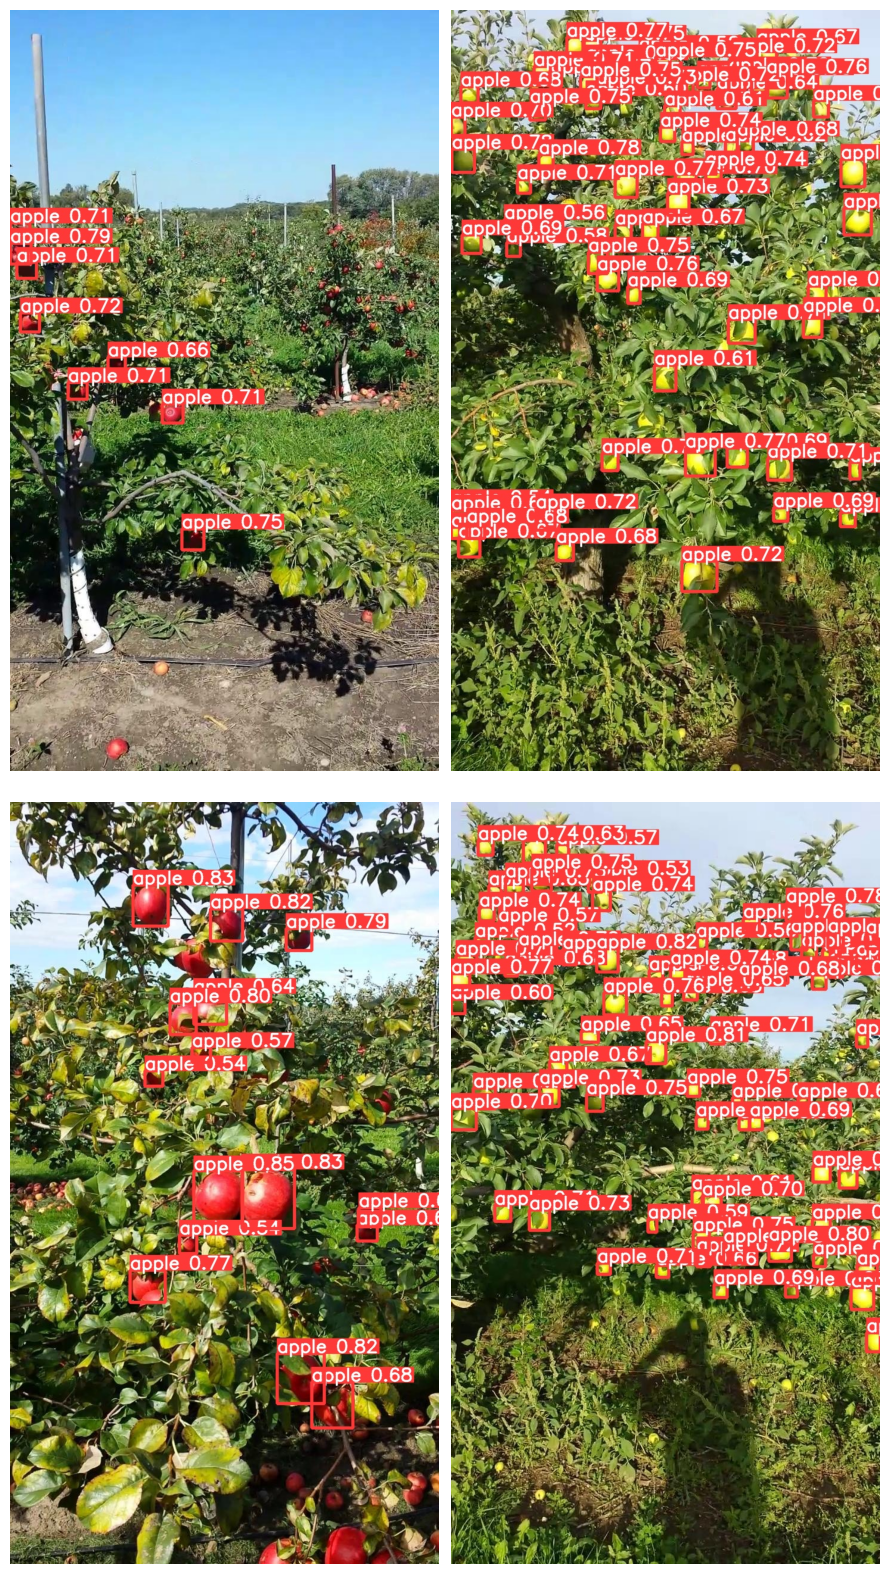

In [54]:
visualize('runs/detect/yolov8s_80e_p6')